## 1. Import

In [85]:
import pandas as pd
import numpy as np

import re
import string
from urllib.parse import urlparse

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

## 2. Data Load

In [86]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# '[.]'을 '.'으로 복구
train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

In [87]:
train_df.isnull().sum()

ID       0
URL      0
label    0
dtype: int64

In [88]:
train_df['label'].value_counts()

label
0    5430159
1    1564897
Name: count, dtype: int64

## 3. Feature-Engineering (FE)

In [89]:
## 새로운 변수 생성
# URL 길이
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

# 특수 문자 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5


In [90]:
# 문자 개수
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters


# 숫자 개수
def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits


train_df["num_letters"] = train_df["URL"].apply(count_letters)
train_df["num_digits"] = train_df["URL"].apply(count_digits)
test_df["num_letters"] = test_df["URL"].apply(count_letters)
test_df["num_digits"] = test_df["URL"].apply(count_digits)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2


In [91]:
# 짧은 링크인지 여부
def has_shortening_service(url):
    pattern = re.compile(r'(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)
    
    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping', 
                                      'post', 'Just', 'bkite', 'snipr', 'fic', 
                                      'loopt', 'doiop', 'kl', 'wp', 
                                      'rubyurl', 'om', 'to', 'lnkd', 
                                      'db', 'adf', 'bitly', 'cur', 'ity', 'q', 
                                      'po', 'bc', 'twitthis', 'j', 'buzurl', 
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
                                      'tweez', 'v', 'tr', 'link', 'zip']
        
        if domain.lower() in common_shortening_services:
            return 1
    return 0

train_df["shortened"] = train_df["URL"].apply(has_shortening_service)
test_df["shortened"] = test_df["URL"].apply(has_shortening_service)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0


In [92]:
# URL에 https 포함 여부
def include_https(url):
    if "https" in url:
        return 1
    return 0

train_df["https"] = train_df["URL"].apply(include_https)
test_df["https"] = test_df["URL"].apply(include_https)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0


In [93]:
# 대문자 포함 여부
def include_uppercase(url):
    if any(x.isupper() for x in url):
        return 1
    return 0

train_df["uppercase"] = train_df["URL"].apply(include_uppercase)
test_df["uppercase"] = test_df["URL"].apply(include_uppercase)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1


In [94]:
# URL에 IP 주소 포함 여부
def include_ip_address(url):
    pattern = re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}')
    match = pattern.search(url)
    
    if match:
        return 1
    return 0

train_df["ip_address"] = train_df["URL"].apply(include_ip_address)
test_df["ip_address"] = test_df["URL"].apply(include_ip_address)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0


In [95]:
# URL에 @ 포함 여부
def include_at_symbol(url):
    if "@" in url:
        return 1
    return 0

train_df["at_symbol"] = train_df["URL"].apply(include_at_symbol)
test_df["at_symbol"] = test_df["URL"].apply(include_at_symbol)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0


In [96]:
# URL에 // 포함 여부
def include_double_slash(url):
    if "//" in url:
        return 1
    return 0

train_df["double_slash"] = train_df["URL"].apply(include_double_slash)
test_df["double_slash"] = test_df["URL"].apply(include_double_slash)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0


In [97]:
# # URL에 포함된 - 개수
# def count_hyphen(url):
#     return url.count("-")

# train_df["hyphen"] = train_df["URL"].apply(count_hyphen)
# test_df["hyphen"] = test_df["URL"].apply(count_hyphen)

# train_df.head()

In [98]:
# 파일확장자 포함 여부
def check_extension(url):
    extensions = [
        ".php",
        ".html",
        ".htm",
        ".hwp",
        ".hwpx",
        ".pptx",
        ".docx",
        ".iso",
        ".js",
        ".lnk",
        ".vbs",
        ".xls",
        ".xml",
        ".zip",
        ".xlsx",
    ]
    for ext in extensions:
        if ext in url:
            return 1
    return 0


train_df["extension_check"] = train_df["URL"].apply(lambda url: check_extension(url))
test_df["extension_check"] = test_df["URL"].apply(lambda url: check_extension(url))

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash,extension_check
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0,0


In [99]:
# URL 무작위성
import math
from collections import Counter

def calculate_entropy(url):
    # 문자 빈도수 계산
    counter = Counter(url)
    length = len(url)
    
    # 섀넌 엔트로피 계산
    entropy = 0
    for count in counter.values():
        probability = count / length
        entropy -= probability * math.log2(probability)
    return entropy

def check_randomness(url):
    # 1. 엔트로피 계산
    entropy = calculate_entropy(url)
    
    # 2. 연속된 숫자나 문자의 최대 길이
    max_consecutive = 1
    current_consecutive = 1
    for i in range(1, len(url)):
        if url[i].isalnum() and url[i-1].isalnum() and url[i].lower() == url[i-1].lower():
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 1
    
    # 3. 숫자와 문자의 교차 패턴 수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i-1].isdigit() and url[i].isalpha()) or \
           (url[i-1].isalpha() and url[i].isdigit()):
            transitions += 1
    
    # 무작위성 점수 계산 (0~1 사이로 정규화)
    entropy_score = min(entropy / 5.0, 1.0)  # 일반적인 URL의 최대 엔트로피를 5로 가정
    consecutive_score = min(max_consecutive / 10.0, 1.0)  # 연속된 문자가 많을수록 낮은 점수
    transition_score = min(transitions / 10.0, 1.0)  # 전환이 많을수록 높은 점수
    
    # 종합 점수 계산 (가중치 조정 가능)
    randomness_score = (entropy_score * 0.5 + 
                       (1 - consecutive_score) * 0.3 + 
                       transition_score * 0.2)
    
    return randomness_score

# 데이터프레임에 적용
train_df['randomness'] = train_df['URL'].apply(check_randomness)
test_df['randomness'] = test_df['URL'].apply(check_randomness)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash,extension_check,randomness
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0,0,0.600827
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0,0,0.587135
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0,0,0.597280
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0,0,0.593377
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0,0,0.667245


In [100]:
# 타이포스쿼팅 구분
def check_typosquatting(url):
    # 자주 사용되는 브랜드/도메인 목록
    common_brands = {
        'google', 'facebook', 'amazon', 'microsoft', 'apple', 
        'netflix', 'paypal', 'twitter', 'instagram', 'linkedin',
        'youtube', 'yahoo', 'gmail', 'whatsapp', 'tiktok',
        'geocities', 'angelfire', 'newadvent', 'wikipedia',
    }
    
    # 타이포스쿼팅 패턴 점수
    score = 0
    
    try:
        # URL 파싱
        parsed = urlparse(url if '//' in url else '//' + url)
        domain = parsed.netloc.lower() if parsed.netloc else url.lower()
        
        # 1. 숫자로 문자 대체 패턴 (예: o -> 0, i -> 1, e -> 3)
        number_substitutions = sum(1 for c in domain if c.isdigit())
        if number_substitutions > 0:
            score += 0.2
        
        # 2. 유사 브랜드 확인
        for brand in common_brands:
            # 레벤슈타인 거리 계산 (문자열 간 편집 거리)
            if brand not in domain:
                similar = False
                # 비슷한 철자 패턴 확인
                patterns = [
                    brand.replace('o', '0'),
                    brand.replace('i', '1'),
                    brand.replace('l', '1'),
                    brand.replace('e', '3'),
                    brand.replace('a', '4'),
                    brand.replace('s', '5'),
                    brand + '-',
                    brand + '_',
                    brand[:-1],  # 마지막 문자 제거
                    ''.join(c + c for c in brand),  # 문자 중복
                ]
                
                for pattern in patterns:
                    if pattern in domain:
                        similar = True
                        break
                
                if similar:
                    score += 0.3
                    break
        
        # 3. 반복되는 문자 패턴
        repeated_chars = re.findall(r'(.)\1{2,}', domain)
        if repeated_chars:
            score += 0.2
        
        # 4. 특수문자 사용
        special_chars = re.findall(r'[-_.]', domain)
        if len(special_chars) > 2:  # 도메인에 특수문자가 많이 사용된 경우
            score += 0.2
        
        # 5. 도메인 길이 확인
        if len(domain) > 30:  # 비정상적으로 긴 도메인
            score += 0.1
            
    except:
        return 0
    
    return min(score, 1.0)  # 최대 점수는 1.0

# 데이터프레임에 적용
train_df['typosquatting'] = train_df['URL'].apply(check_typosquatting)
test_df['typosquatting'] = test_df['URL'].apply(check_typosquatting)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash,extension_check,randomness,typosquatting
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0,0,0.600827,0.2
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0,0,0.587135,0.2
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0,0,0.597280,0.0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0,0,0.593377,0.2
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0,0,0.667245,0.4


In [101]:
# 피싱 키워드 포함 여부
def include_fishing_keyword(url):
    keywords = [
        "signin", "login", "account", "update", "reset", "urgent", "alert", 
        "security", "support", "banking", "secure", "verify", "password",
        "payment", "customer", "service", "confirm", "approve", "activate",
        "activation", "member", "center", "info", "identity", "register",
        "validation", "authenticate", "recovery", "unblock", "resolution",
        "unlock", "verification", "bank", "transfer", "card",
        "free", "event", "prize"
    ]
    
    url_lower = url.lower()
    for keyword in keywords:
        if keyword in url_lower:
            return 1
    return 0

train_df["fishing_keyword"] = train_df["URL"].apply(include_fishing_keyword)
test_df["fishing_keyword"] = test_df["URL"].apply(include_fishing_keyword)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash,extension_check,randomness,typosquatting,fishing_keyword
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0,0,0.600827,0.2,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0,0,0.587135,0.2,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0,0,0.597280,0.0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0,0,0.593377,0.2,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0,0,0.667245,0.4,1


In [102]:
# URL 구성 요소 파싱
def parse_url_components(url):
    try:
        if not url.startswith('http://') and not url.startswith('https://'):
            url = 'http://' + url
            
        parsed = urlparse(url)
        domain = parsed.netloc
        domain_parts = domain.split('.')
        
        components = {
            'domain': domain,
            'path': parsed.path if parsed.path else '',
            'params': parsed.params if parsed.params else '',
            'query': parsed.query if parsed.query else '',
            'fragment': parsed.fragment if parsed.fragment else '',
            'tld': domain_parts[-1] if domain_parts else '',
            'sld': domain_parts[-2] if len(domain_parts) > 1 else '',
            'subdomain': '.'.join(domain_parts[:-2]) if len(domain_parts) > 2 else ''
        }
        
        return components
        
    except:
        return {
            'domain': '', 'path': '', 'params': '',
            'query': '', 'fragment': '', 'tld': '',
            'sld': '', 'subdomain': ''
        }

for df in [train_df, test_df]:
    components = df['URL'].apply(parse_url_components)
    
    df['url_path'] = components.apply(lambda x: x['path'])
    df['url_params'] = components.apply(lambda x: x['params'])
    df['url_query'] = components.apply(lambda x: x['query'])
    df['url_fragment'] = components.apply(lambda x: x['fragment'])
    df['url_tld'] = components.apply(lambda x: x['tld'])
    df['url_sld'] = components.apply(lambda x: x['sld'])
    df['url_subdomain'] = components.apply(lambda x: x['subdomain'])

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,...,randomness,typosquatting,fishing_keyword,url_path,url_params,url_query,url_fragment,url_tld,url_sld,url_subdomain
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,...,0.600827,0.2,0,,,,,pl,gov,poznan.wuoz
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,...,0.587135,0.2,0,,,,,jp,kochi,vill.okawa
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,...,0.597280,0.0,0,,,,,om,co,nationalfinance
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,...,0.593377,0.2,0,,,,,jp,hokkaido,town.ozora
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,...,0.667245,0.4,1,/online/Login,,,,irish,ie-news,open24


In [27]:
train_df.to_csv('train_features.csv', index=False)
test_df.to_csv('test_features.csv', index=False)

### EDA 

In [40]:
train_df = pd.read_csv('train_features.csv')
test_df = pd.read_csv('test_features.csv')

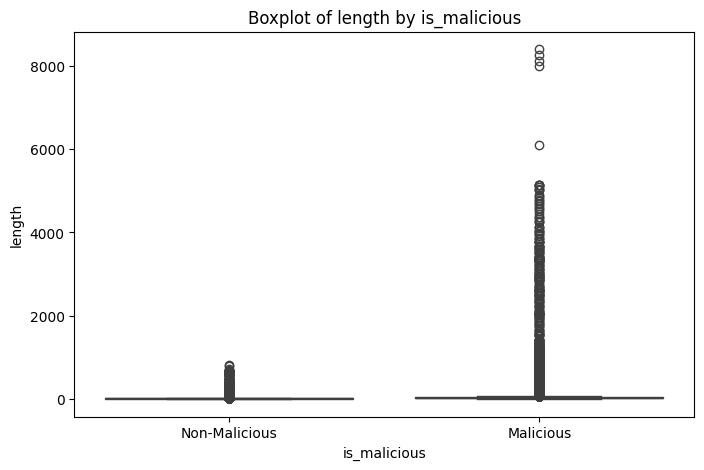

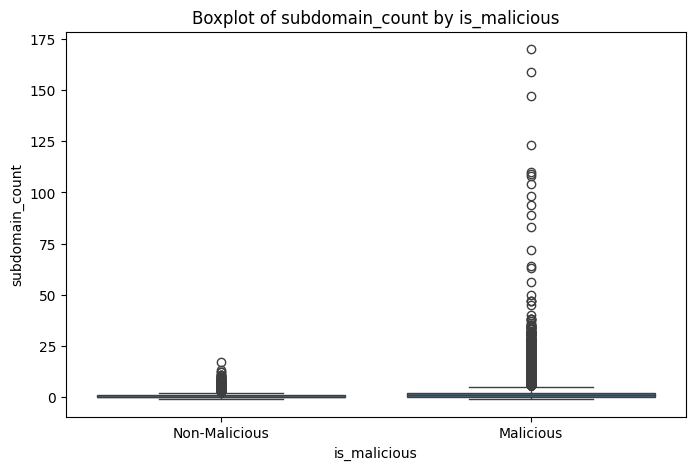

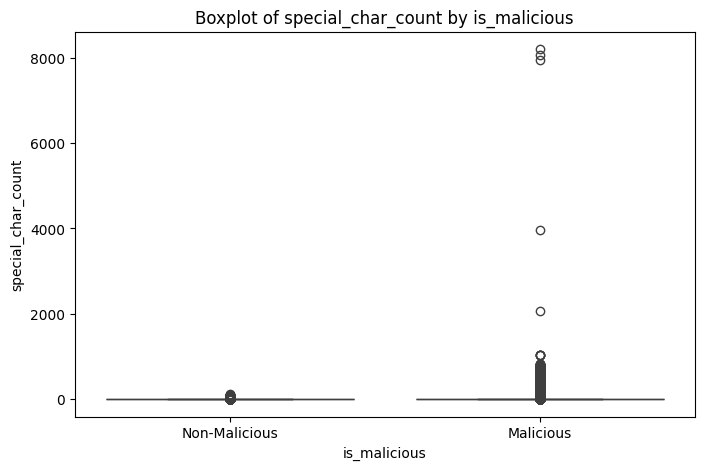

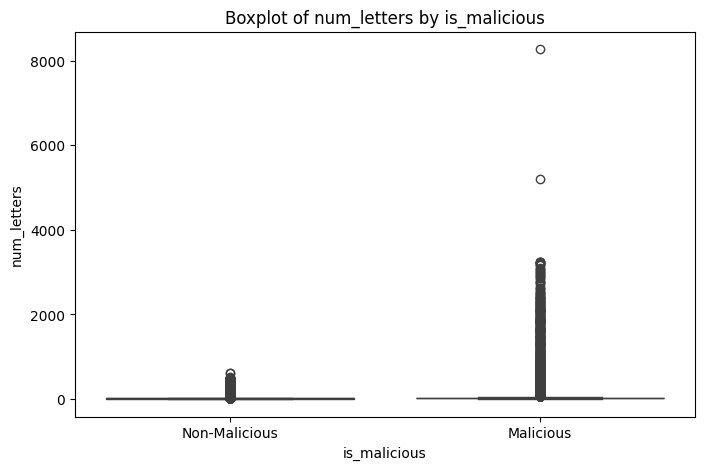

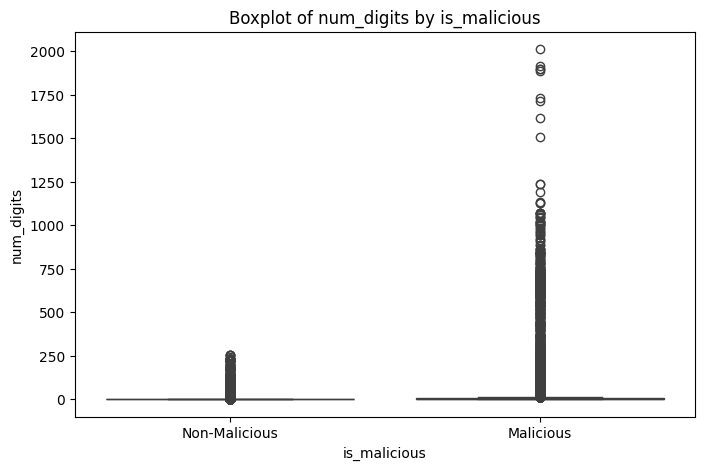

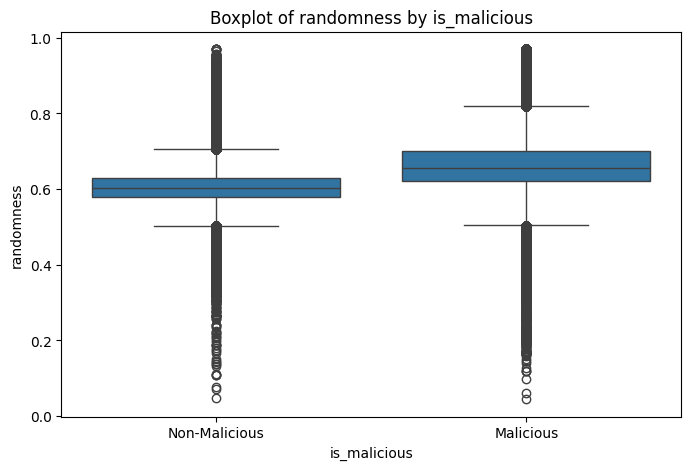

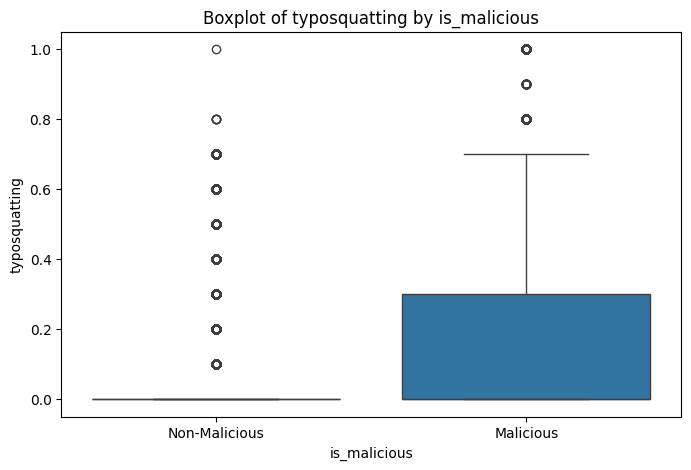

In [99]:
variables = ['length', 'subdomain_count', 'special_char_count', 'num_letters', 'num_digits', 'randomness', 'typosquatting']

for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=var)
    plt.title(f"Boxplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

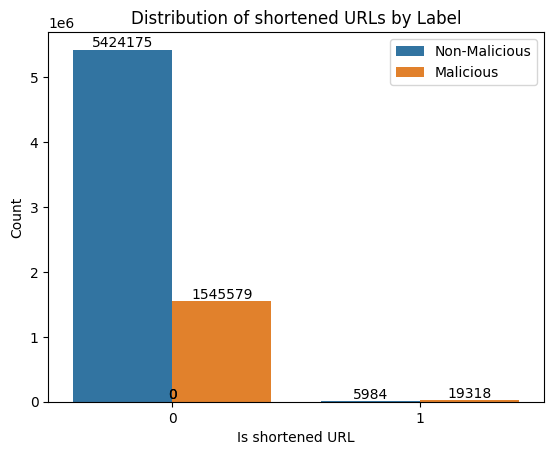

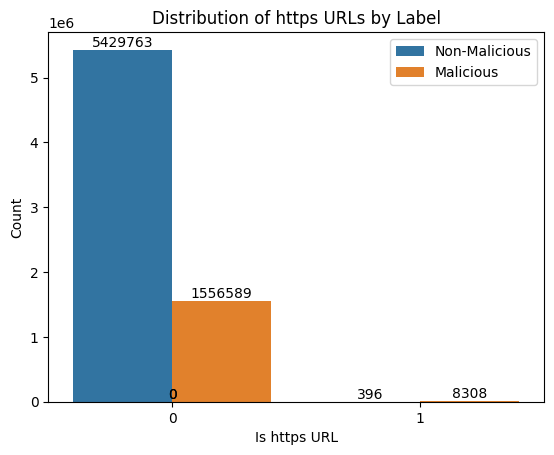

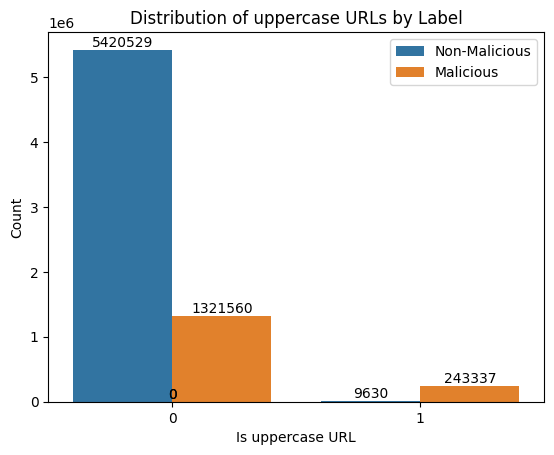

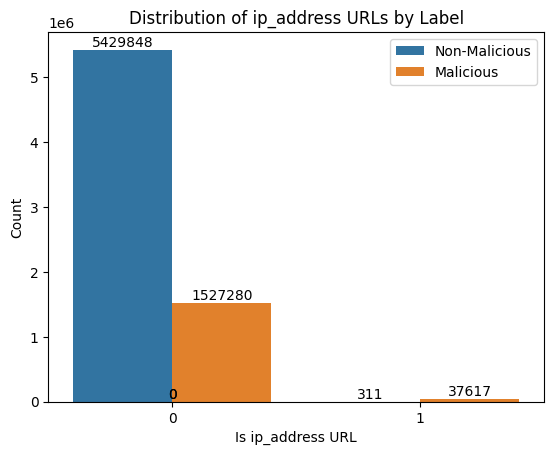

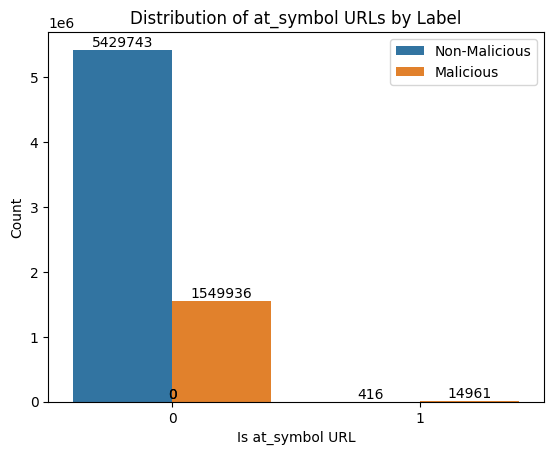

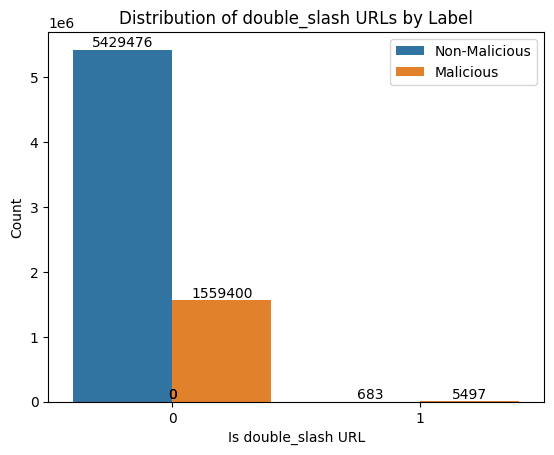

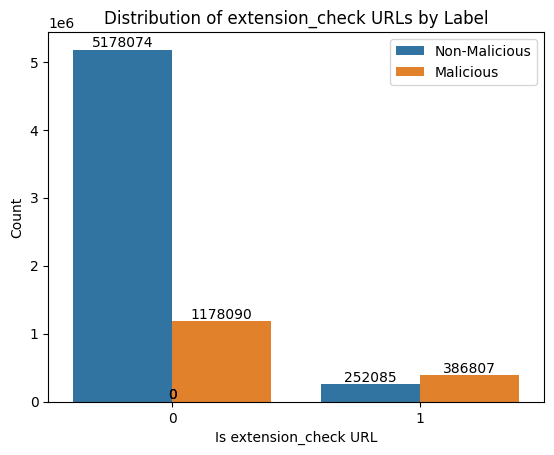

In [100]:
variables = ['shortened', 'https', 'uppercase', 'ip_address', 'at_symbol', 'double_slash', 'extension_check']

for var in variables:
    plt.figure(figsize=(6.4, 4.8))
    ax = sns.countplot(data=train_df, x=var, hue='label')

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')

    plt.title(f'Distribution of {var} URLs by Label')
    plt.xlabel(f'Is {var} URL')
    plt.ylabel('Count')
    plt.legend(labels=['Non-Malicious', 'Malicious'])
    plt.show()

- URL 길이 길수록 악성 URL 가능성 높음
- 서브도메인 수 많을수록 악성 URL 가능성 높음
- 특수문자 많이 포함할수록 악성 URL 가능성 높음
- 숫자 많이 포함할수록 악성 URL 가능성 높음(문자도 동일)
- 짧은 링크일 경우 악성 URL 가능성 높음
- https가 프로토콜로서 사용되지 않는 경우 악성 URL 가능성 높음
- 대문자 포함 시 악성 URL 가능성 높음

### 상관 관계 분석

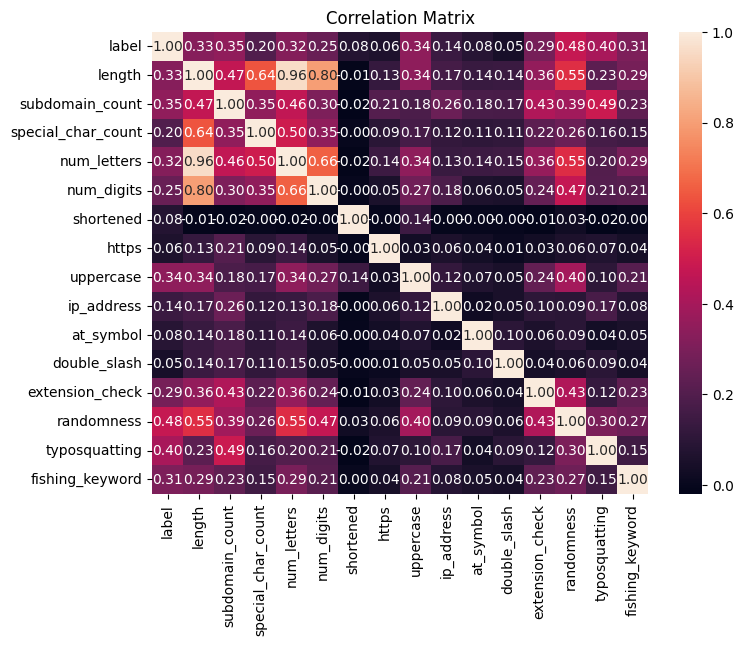

In [ ]:
correlation_matrix = train_df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

-  EDA 결과에 따른 가설 설정 

    1. URL의 길이가 길수록 악성 URL일 확률이 높을 것이다. -> 악성 URL은 난독화와 탐지 회피를 위해 길이가 긴 경우가 많다.
    2. 서브도메인이 많을수록 악성 URL일 확률이 높을 것이다. -> 서브도메인은 피싱과 사용자 혼란을 유발하는 데 자주 활용된다.
    3. 특수문자가 많을수록 악성 URL일 확률이 높을 것이다. -> 특수문자는 난독화와 위장 목적으로 사용된다.


## 4. Pre-processing (전처리)

In [60]:
train_df.isnull().sum()

ID                    0
URL                   0
label                 0
length                0
subdomain_count       0
special_char_count    0
num_letters           0
num_digits            0
shortened             0
https                 0
uppercase             0
ip_address            0
at_symbol             0
double_slash          0
extension_check       0
randomness            0
typosquatting         0
fishing_keyword       0
url_path              0
url_params            0
url_query             0
url_fragment          0
url_tld               0
url_sld               0
url_subdomain         0
dtype: int64

In [66]:
X = train_df.drop(columns=['ID', 'label'])
y = train_df['label']

X_test = test_df.drop(columns=['ID'])

In [67]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

## 5. K-Fold Model Training (모델 학습)

In [69]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
models = []
auc_scores = []

categorical_cols = X.select_dtypes(include='object').columns.tolist()

for idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    print('-'*40)
    print(f'Fold {idx + 1}')
    
    model = CatBoostClassifier(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        random_seed=42,
        cat_features=categorical_cols,
        eval_metric="AUC",
        verbose=10
    )
    
    eval_set = [(X_val, y_val)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        # early_stopping_rounds=5
    )
    
    models.append(model)
    
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Fold {idx + 1} CV ROC-AUC: {auc:.4f}")
    print('-'*40)
    auc_scores.append(auc)
    
    break

print(f"K-Fold 평균 ROC-AUC: {np.mean(auc_scores):.4f}")

----------------------------------------
Fold 1
0:	test: 0.8910749	best: 0.8910749 (0)	total: 2.37s	remaining: 3m 54s
10:	test: 0.9777039	best: 0.9777039 (10)	total: 18.3s	remaining: 2m 28s
20:	test: 0.9817071	best: 0.9817071 (20)	total: 30.9s	remaining: 1m 56s
30:	test: 0.9824103	best: 0.9824103 (30)	total: 43.3s	remaining: 1m 36s
40:	test: 0.9830034	best: 0.9830034 (40)	total: 55.9s	remaining: 1m 20s
50:	test: 0.9834659	best: 0.9834659 (50)	total: 1m 8s	remaining: 1m 5s
60:	test: 0.9837180	best: 0.9837180 (60)	total: 1m 20s	remaining: 51.7s
70:	test: 0.9838991	best: 0.9838991 (70)	total: 1m 33s	remaining: 38.2s
80:	test: 0.9840449	best: 0.9840449 (80)	total: 1m 46s	remaining: 25.1s
90:	test: 0.9841725	best: 0.9841725 (90)	total: 2m	remaining: 11.9s
99:	test: 0.9842348	best: 0.9842348 (99)	total: 2m 11s	remaining: 0us

bestTest = 0.984234822
bestIteration = 99

Fold 1 CV ROC-AUC: 0.9842
----------------------------------------
K-Fold 평균 ROC-AUC: 0.9842


## 6. K-Fold Ensemble Inference (K-Fold 앙상블 추론)

In [ ]:
test_probabilities = np.zeros(len(X_test))

for model in models:
    test_probabilities += model.predict_proba(X_test)[:, 1]

test_probabilities /= len(models)
print('Inference Done.')

Inference Done.


## 7. Submission (제출 파일 생성)

In [ ]:
test_df['probability'] = test_probabilities
test_df[['ID', 'probability']].to_csv('./submission.csv', index=False)
print('Done.')

Done.
